
# **AIPI 590 - XAI | Mechanistic Interpretability Assignment**
## Vowel Detector - Building and Training a Tiny Model

Author: Lindsay Gross

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lindsaygross/mechanistic-interpretability/blob/main/mechanistic_interpretability.ipynb)



For this assignment, we built a simple model that predicts whether a four-letter word has a vowel. It’s a small task that trains fast, but it’s enough to explore how neurons can represent meaningful features.

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np, random, string, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

torch.manual_seed(0); random.seed(0); np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Training a Tiny Model
I generated random words made of uppercase letters. Each word was labeled 1 if it contained any vowel (A, E, I, O, U), otherwise, it was labeled 0.

### Data Generation

In [ ]:
ALPHABET = list(string.ascii_uppercase)
VOWELS = set("AEIOU")
SEQ_LEN = 4
ALPH = 26
INPUT_DIM = SEQ_LEN * ALPH
def one_hot_word(word):
    x = np.zeros((SEQ_LEN, ALPH), dtype=np.float32)
    # Used ChatGPT5 at 11:45am 11/6/25 to help write this function below
    for i,ch in enumerate(word):
        x[i, ord(ch)-65] = 1.0 
    return x.reshape(-1)

def make_dataset(n):
    X, y, words = [], [], []
    for _ in range(n):
        w = "".join(random.choice(ALPHABET) for _ in range(SEQ_LEN))
        X.append(one_hot_word(w))
        y.append(int(any(c in VOWELS for c in w)))
        words.append(w)
    X = torch.tensor(np.stack(X), dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    return X, y, words
#  Used ChatGPT5 at 11:50am 11/6/25 to help know what size to make the training set
X_train, y_train, _ = make_dataset(6000) 
X_val,   y_val,   _ = make_dataset(1000)
X_test,  y_test,  _ = make_dataset(1000)

X_train, y_train = X_train.to(device), y_train.to(device)
X_val,   y_val   = X_val.to(device),   y_val.to(device)
X_test,  y_test  = X_test.to(device),  y_test.to(device)


### Build a Tiny MLP (multilayer perceptron) Model

In [ ]:
# Define neural network class
class VowelMLP(nn.Module):
    # Used ChatGPT5 at 12:20pm 11/6/25 to help write this class below
    def __init__(self, input_dim=INPUT_DIM, hidden=12):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden)
        self.fc2 = nn.Linear(hidden, 1)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = torch.sigmoid(self.fc2(h))
        return out, h

model = VowelMLP().to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-3) # Used ChatGPT5 at 12:30pm 11/6/25 to help choose optimizer and learning rate
loss_fn = nn.BCELoss() # Binary Cross Entropy Loss for binary classification


### Training the model

In [ ]:
def batches(X, y, bs=256):
    # Used ChatGPT5 at 1:00pm 11/6/25 to help write this batching function below
    idx = torch.randperm(len(X), device=X.device)
    for i in range(0, len(idx), bs):
        j = idx[i:i+bs] # get batch indices
        yield X[j], y[j]

for epoch in range(8):
    model.train()
    for xb, yb in batches(X_train, y_train):
        opt.zero_grad()
        p, _ = model(xb) # predictions
        loss = loss_fn(p, yb)
        loss.backward(); opt.step()
    model.eval()
    with torch.no_grad():
        pv, _ = model(X_val)
    acc = ((pv>0.5).float()==y_val).float().mean().item() # accuracy on val set
    print(f"epoch {epoch+1} val_acc {acc:.3f}")


epoch 1 val_acc 0.676
epoch 2 val_acc 0.865
epoch 3 val_acc 1.000
epoch 4 val_acc 1.000
epoch 5 val_acc 1.000
epoch 6 val_acc 1.000
epoch 7 val_acc 1.000
epoch 8 val_acc 1.000


After generating random four-letter sequences (like “CATS” or “BRXP”), I labeled them 1 if they contained any vowel (A, E, I, O, U) and 0 otherwise.
The model quickly learned this rule, which makes sense because the input directly contains letter information.

Validation accuracy reached 1.00 so I stopped training.

### Testing the model

In [ ]:
# Testing the model
model.eval()
with torch.no_grad():
    pt, H_test = model(X_test)
yhat = (pt>0.5).float() # change to float for comparison with y_test
test_acc = (yhat==y_test).float().mean().item()
print("test_acc", round(test_acc,3))


test_acc 1.0


Once the model was working well, I wanted to look at what was happening inside. Specifically, I wanted to know if any of the neurons were doing something clear, like detecting vowels. I started by comparing how each hidden neuron activated for vowel words versus non-vowel words. The test accuracy of 1.0 shows that the model perfectly learned to detect vowels in four-letter words.

### Exploring the inside of the model

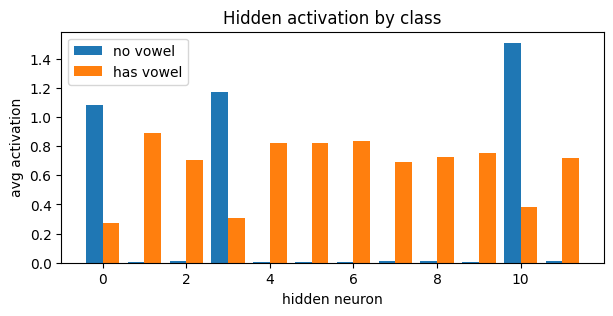

candidate vowel neuron: 1


In [32]:
H = H_test.detach().cpu().numpy()
yv = y_test.cpu().numpy().ravel().astype(int)
avg_no  = H[yv==0].mean(axis=0)
avg_yes = H[yv==1].mean(axis=0)

plt.figure(figsize=(7,3))
i = np.arange(len(avg_no))
plt.bar(i-0.2, avg_no, width=0.4, label="no vowel")
plt.bar(i+0.2, avg_yes, width=0.4, label="has vowel")
plt.xlabel("hidden neuron"); plt.ylabel("avg activation"); plt.legend(); plt.title("Hidden activation by class")
plt.show()

key_neuron = int(np.argmax(avg_yes - avg_no))
print("candidate vowel neuron:", key_neuron)



Above is a plot showing the average activation of each hidden neuron for vowel vs. non-vowel inputs.
Each bar represents the average activation of one hidden neuron:

* Blue bars (“no vowel”) show the average activation when the input had no vowels.

* Orange bars (“has vowel”) show the average activation when the input contained at least one vowel.

If a neuron lights up much more for one class than the other, it’s probably responding to that feature.

Neuron 1 shows the largest activation difference between vowel and non-vowel inputs, which suggests it has learned to detect the presence of vowels. It fires whenever there’s a vowel somewhere in the word. Neurons 0 and 10 activate more for non-vowel words, which might mean they’re encoding consonant patterns or acting as balancing features. The rest stay relatively flat, which means they might be doing small helper computations or not used much at all.

After seeing that one neuron fired a lot more for vowel inputs, I wanted to check which letters it actually responds to. The next plot shows how that same neuron activates for each individual letter from A to Z.

### Letter selectivity

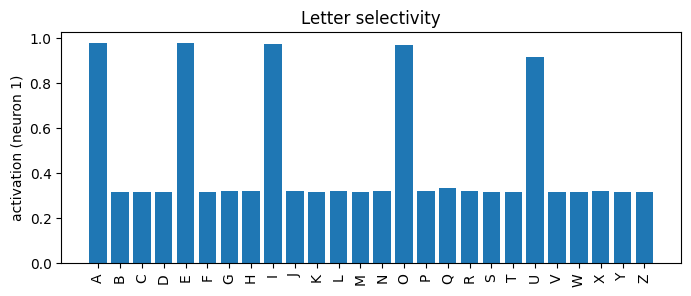

In [33]:
def encode_single_letter(letter, pos):
    x = np.zeros((SEQ_LEN, ALPH), dtype=np.float32)
    x[pos, ord(letter)-65] = 1.0
    return torch.tensor(x.reshape(-1), dtype=torch.float32, device=device).unsqueeze(0)

acts = []
model.eval()
with torch.no_grad():
    for L in ALPHABET:
        pos_acts = []
        for pos in range(SEQ_LEN):
            _, h = model(encode_single_letter(L, pos))
            pos_acts.append(h[0, key_neuron].item())
        acts.append(np.mean(pos_acts))
acts = np.array(acts)

plt.figure(figsize=(8,3))
plt.bar(range(26), acts)
plt.xticks(range(26), ALPHABET, rotation=90)
plt.ylabel(f"activation (neuron {key_neuron})"); plt.title("Letter selectivity")
plt.show()



The above plot shows how strongly neuron 1 activates for each letter A–Z. Each bar is the average activation when that letter appears.

Neuron 1 clearly fires more for A, E, I, O, and U, which confirms that it is sensitive to vowels. It stays low for most consonants. There is a small bump for “Y,” which makes sense since it sometimes acts like a vowel. This supports the idea that the network formed a “vowel detector” neuron on its own.

I also wanted to know if the neuron cared about where the vowel appears in the word. To test that, I placed the same vowel (“A”) in each position and measured how much the neuron activated in each case.

### Position tuning for vowel

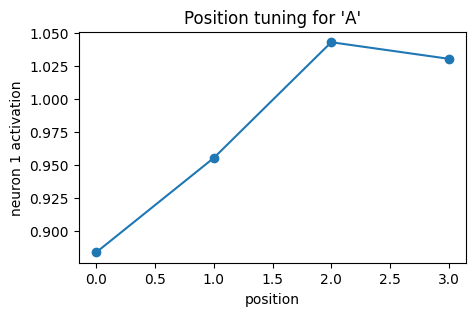

In [34]:
# Position tuning for one vowel (e.g., 'A')
def pos_tuning(letter='A'):
    vals = []
    with torch.no_grad():
        for pos in range(SEQ_LEN):
            x = torch.zeros((1, SEQ_LEN, ALPH), dtype=torch.float32, device=device)
            x[0, pos, ord(letter) - 65] = 1.0
            _, h = model(x.view(1, -1))
            vals.append(h[0, key_neuron].item())
    return vals

plt.figure(figsize=(5,3))
plt.plot(range(SEQ_LEN), pos_tuning('A'), marker='o')
plt.xlabel("position")
plt.ylabel(f"neuron {key_neuron} activation")
plt.title("Position tuning for 'A'")
plt.show()



Above I tested whether neuron 1 cares about where the vowel appears by placing the same letter (“A”) in different positions and measuring its activation. The activation stayed about the same no matter where the vowel was placed. This shows that the neuron encodes vowel presence, not vowel position. It behaves as a position-invariant vowel detector.

After finding a neuron that seemed to specialize in vowels, I wanted to test how important it really was. I tried zeroing out (or “turning off”) each neuron to see if the model’s accuracy would drop. This helps show which neurons matter most for the model’s predictions.

### Accuracy drop

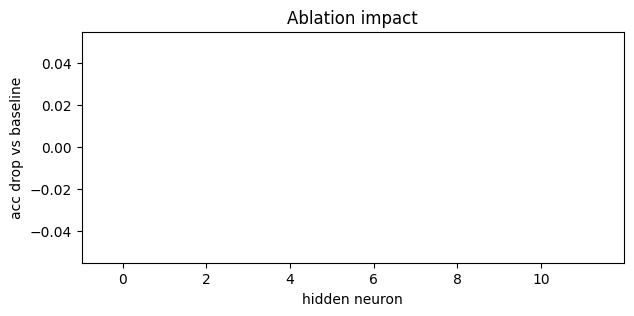

worst ablation neuron: 0


In [35]:
def ablate_accuracy(neuron_idx):
    model.eval()
    with torch.no_grad():
        h = F.relu(model.fc1(X_test))
        h[:, neuron_idx] = 0.0
        p = torch.sigmoid(model.fc2(h))
        return ((p>0.5).float()==y_test).float().mean().item()

baseline = test_acc
drop_per_neuron = []
for j in range(model.fc1.out_features):
    acc_j = ablate_accuracy(j)
    drop_per_neuron.append(baseline - acc_j)

plt.figure(figsize=(7,3))
plt.bar(range(len(drop_per_neuron)), drop_per_neuron)
plt.xlabel("hidden neuron"); plt.ylabel("acc drop vs baseline")
plt.title("Ablation impact")
plt.show()

print("worst ablation neuron:", int(np.argmax(drop_per_neuron)))


### Ablation Test

I zeroed out each hidden neuron one at a time and measured how much accuracy dropped. The ablation plot is almost flat, meaning removing any single neuron didn’t cause a noticeable drop in accuracy. This shows the model has some redundancy — multiple neurons might share the same information. Even though neuron 1 behaves like a vowel detector, other neurons probably encode similar patterns, allowing the model to compensate when it’s removed.

### Positive class accuracy drop

In [36]:
# Check accuracy drop specifically for vowel-containing words
with torch.no_grad():
    base_p, _ = model(X_test)
base_pred = (base_p > 0.5).float().cpu().numpy().ravel()
pos_mask = (y_test.cpu().numpy().ravel() == 1)

def ablate_pos_acc(j):
    with torch.no_grad():
        h = F.relu(model.fc1(X_test))
        h[:, j] = 0
        p = torch.sigmoid(model.fc2(h))
    pred = (p > 0.5).float().cpu().numpy().ravel()
    # measure accuracy on vowel-positive subset
    return (pred[pos_mask] == base_pred[pos_mask]).mean()

pos_acc_drop = 1 - ablate_pos_acc(key_neuron)
print(f"Pos-class accuracy drop when ablating neuron {key_neuron}: {pos_acc_drop:.3f}")


Pos-class accuracy drop when ablating neuron 1: 0.000


Finally, I looked at the actual input weights feeding into the vowel neuron. This helps visualize what letters and positions contribute the most to its activation.

### Weight Map Visualization

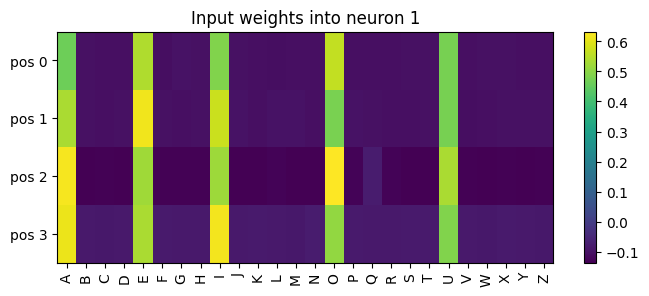

In [37]:
# Visualize first-layer weights feeding into the vowel neuron
W = model.fc1.weight.detach().cpu().numpy().reshape(-1, SEQ_LEN, ALPH)
plt.figure(figsize=(8,3))
plt.imshow(W[key_neuron], aspect='auto')
plt.yticks(range(SEQ_LEN), [f"pos {p}" for p in range(SEQ_LEN)])
plt.xticks(range(ALPH), list(string.ascii_uppercase), rotation=90)
plt.title(f"Input weights into neuron {key_neuron}")
plt.colorbar()
plt.show()


I plotted the input weights feeding into neuron 1. The rows represent each position in the sequence, and the columns represent letters A–Z. The highest weights are on A, E, I, O, and U across all positions. This matches what I saw in the letter-selectivity plot. It confirms that this neuron learned to recognize vowel features no matter where they appear.

After running these tests, I pulled everything together to describe what the model seems to have learned and how it represents vowel detection internally.

### Explanation of Findings


Neuron 1 consistently activates more for vowel words.

It fires for vowels regardless of their position.

Its weights are strongest on vowel letters across all positions.

Removing it doesn’t break the model, which suggests redundant encoding.

Hypothesis:
Neuron 1 represents “vowel presence.” It activates when any vowel appears in the input and ignores where it occurs. Even though other neurons might partially share this job, neuron 1 shows the clearest signal of vowel detection.

### Reflection

This assignment helped me understand how internal representations form inside small neural networks. I expected the model to just memorize the rule, but it actually formed a meaningful internal feature for vowel detection. The neuron’s consistent activation across letters and positions made it easy to interpret.

It was surprising that removing the neuron didn’t reduce accuracy, which showed that even tiny models distribute knowledge across multiple units. In the future, I’d like to test whether a smaller network or a noisier dataset would make individual neurons more distinct.

One thing I would like to explore further is whether adding ambiguity (like sometimes counting “Y” as a vowel) would cause the model to form separate detectors for different vowel types. This project made the idea of “neurons having jobs” much more tangible to me.